In [ ]:
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib import cm
from os import listdir
from PIL import Image
import numpy as np
import torchvision
import cv2 as cv
from torchvision import models
import torch
import pywt
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import save_image
import torch.optim as optim
import shutil
import pandas as pd
!pip install split-folders
import splitfolders
from sklearn.svm import SVC
from tqdm import tqdm
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

#!pip install tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Defining Data Loader

Set random seed

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "/content/drive/MyDrive/ML Project/Diabetic Retinopathy/Fungus of Retina/"
print("The data lies here =>", root_dir)

We're using => cpu
The data lies here => /content/drive/MyDrive/ML Project/Diabetic Retinopathy/Fungus of Retina/


Defining Transformers

In [ ]:
image_transforms = {
    "train": transforms.Compose([
                transforms.Resize((64,64)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    "test": transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor(),
           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    }

Initialize Datasets


In [ ]:
rps_dataset = datasets.ImageFolder(root = root_dir + "train (1)",
                                   transform = image_transforms["train"]
                                  )
rps_dataset

Dataset ImageFolder
    Number of datapoints: 9798
    Root location: /content/drive/MyDrive/ML Project/Diabetic Retinopathy/Fungus of Retina/train (1)
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

The class_to_idx function is pre-built in PyTorch. It returns class ID's present in the dataset.

In [ ]:
rps_dataset.class_to_idx

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

We will create our own dictionary that maps class names to numbers

In [ ]:
idx2class = {v: k for k, v in rps_dataset.class_to_idx.items()}
idx2class

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}

Function that takes in a dataset object and returns a dictionary that contains the count of class samples. We will use this dictionary to construct plots and observe the class distribution in our data.
get_class_distribution() takes in an argument called dataset_obj.



In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

In [ ]:
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(rps_dataset), plot_title="Entire Dataset (before train/val/test split)")

# Get Train and Validation Samples
We use SubsetRandomSampler to make our train and validation loaders. SubsetRandomSampler is used so that each batch receives a random distribution of classes.


In [ ]:
rps_dataset_size = len(rps_dataset)
rps_dataset_indices = list(range(rps_dataset_size))

Shuffle the list of indices using np.shuffle.

In [ ]:
np.random.shuffle(rps_dataset_indices)

Create the split index. We choose the split index to be 20% (0.2) of the dataset size.

In [ ]:
val_split_index = int(np.floor(0.2 * rps_dataset_size))

Slice the lists to obtain 2 lists of indices, one for train and other for test.

> 0-----------val_split_index------------------------------n 

---


> Train => val_split_index to n
Indented block


Val => 0 to val_split_index

In [ ]:
train_idx = rps_dataset_indices[val_split_index:]
val_idx = rps_dataset_indices[:val_split_index]

Create samplers

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Now lets load our datasets

In [ ]:
rps_dataset_test = datasets.ImageFolder(root = root_dir + "test (1)",
                                        transform = image_transforms["test"])
rps_dataset_test


Dataset ImageFolder
    Number of datapoints: 2102
    Root location: /content/drive/MyDrive/ML Project/Diabetic Retinopathy/Fungus of Retina/test (1)
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

# Train, Validation, and Test Dataloader


my_collate function skips files that are none, just pass it as a DataLoader parameter

In [ ]:
def my_collate(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)

In [ ]:
train_loader = DataLoader(dataset=rps_dataset, shuffle=False, batch_size=128, sampler=train_sampler,  collate_fn=my_collate)
val_loader = DataLoader(dataset=rps_dataset, shuffle=False, batch_size=1, sampler=val_sampler, collate_fn=my_collate)
test_loader = DataLoader(dataset=rps_dataset_test, shuffle=False, batch_size=1,collate_fn=my_collate)

# Explore The Data
To explore our train and val data-loaders, let’s create a new function that takes in a data-loader and returns a dictionary with class counts.
* Initialize a dictionary count_dict to all 0s.
* If the batch_size of the dataloader_obj is 1, then loop through the dataloader_obj and update the counter.
* Else, if the batch_size of the dataloader_obj is not 1, then loop through the dataloader_obj to obtain batches. Loop through the batches to obtain individual tensors. 
* Now, updated the counter accordingly.


In [ ]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, rps_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, rps_dataset), plot_title="Val Set", ax=axes[1])

single_batch is a list of 2 elements. 
* The first element (0th index) contains the image tensors 
* the second element (1st index) contains the output labels.
Here’s the first element of the list which is a tensor. 


---


This tensor is of the shape `(batch, channels, height, width)`.

In [ ]:
single_batch = next(iter(train_loader))

In [ ]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 2, 1, 3, 2, 0, 2, 0, 0, 4, 1, 2, 0, 2,
        2, 0, 2, 0, 0, 0, 2, 3, 2, 0, 2, 0, 2, 1, 1, 3, 1, 2, 1, 1, 0, 2, 0, 0,
        4, 2, 2, 0, 2, 1, 0, 0, 2, 2, 1, 0, 0, 3, 1, 2, 0, 1, 0, 2, 3, 2, 1, 3,
        2, 0, 2, 2, 1, 3, 1, 2, 2, 3, 2, 2, 0, 2, 2, 0, 2, 1, 4, 2, 0, 1, 2, 2,
        0, 2, 3, 1, 0, 1, 4, 4, 2, 0, 2, 2, 2, 0, 0, 2, 4, 2, 3, 2, 1, 0, 2, 3,
        2, 0, 4, 2, 0, 0, 0, 2])

Output label tensor shape:  torch.Size([128])


To plot the image, we’ll use plt.imshow from matloptlib. It expects the image dimension to be (height, width, channels). We'll .permute() our single image tensor to plot it.

In [ ]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


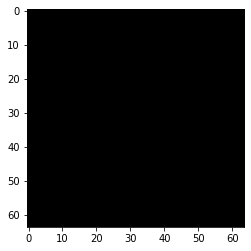

In [ ]:
plt.imshow(single_image.permute(2, 1, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


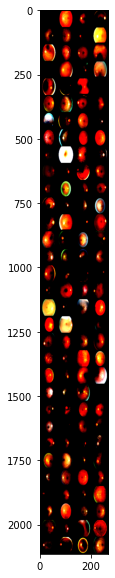

In [ ]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the
# output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

# Now let's train the code

For calculating the accuracy we compare the predicted classes and the actual classes to calculate the accuracy.

In [ ]:
def multi_acc(y_pred, y_test): 
    correct_pred = (y_pred == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

# AlexNet

In [ ]:
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# model = models.alexnet(pretrained)
classifier = list(alexnet.classifier.children())
alexnet.classifier = nn.Sequential(*classifier[:-1])
num_classes = 5
alexnet.classifier.add_module(
    '5', nn.Linear(classifier[-1].in_features, num_classes))
alexnet.eval()
alexnet.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model = alexnet
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
loss_fn   = nn.MSELoss() #CrossEntropyLoss with class_weights.

# ResNet34

In [ ]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True) #Downloads the resnet34 model which is pretrained on Imagenet dataset.

#Replace the Final layer of pretrained resnet34 with 4 new layers.
model.fc = nn.Sequential(nn.Linear(512,256),
                         nn.ReLU(inplace=True),
                         nn.Linear(256,128),
                         nn.ReLU(inplace=True),
                         nn.Linear(128,64),
                         nn.ReLU(inplace=True),
                         nn.Linear(64,5),    
                    )
    
model.eval()
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Visualize Loss and Accuracy
To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and loss_stats dictionaries.


In [ ]:
# path to save model, optimizer ....
# to then read and resume training
PATH = "/content/drive/MyDrive/ML Project/Diabetic Retinopathy/Saved Model/alexnet.pt"

To load the model use

In [ ]:
class_weights = torch.tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827],dtype=torch.float).to(device)

optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
criterion = nn.MSELoss() 

nb_epochs = 60

In [ ]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
print("Begin training.")
for e in tqdm(range(1, nb_epochs)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)
        y_train_pred = torch.argmax(y_train_pred, dim=1)

        y_train_pred = y_train_pred.to(torch.float32) 
        y_train_batch = y_train_batch.to(torch.float32) 

        train_loss = criterion(y_train_pred, y_train_batch)
        train_loss.requires_grad_(requires_grad=True)

        train_acc = multi_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            y_val_pred = torch.argmax(y_val_pred, dim=1)

            y_val_pred = y_val_pred.to(torch.float32) 
            y_val_batch = y_val_batch.to(torch.float32) 

            val_loss = criterion(y_val_pred, y_val_batch)
            val_loss.requires_grad_(requires_grad=True)

            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

# Save Model

In [ ]:
PATH = "/content/drive/MyDrive/ML Project/Diabetic Retinopathy/Saved Model/alexnet.pt"
torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

# Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

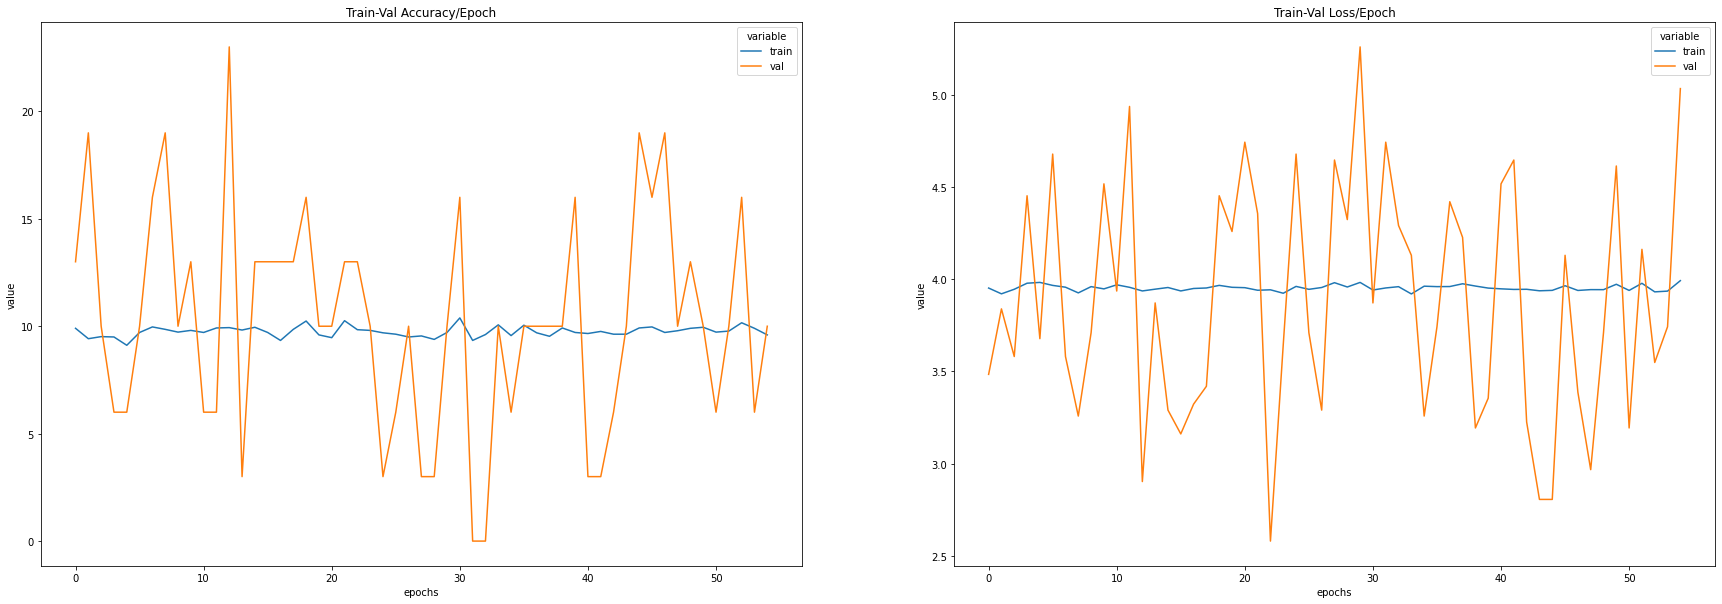

In [ ]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
print("Begin training.")
for e in tqdm(range(1, 100)):
    # TRAINING
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
       
        y_train_pred = model(X_train_batch)
        y_train_pred = torch.argmax(y_train_pred, dim=1)


        y_train_pred = y_train_pred.to(torch.float32) 
        y_train_batch = y_train_batch.to(torch.float32) 


        train_loss = criterion(y_train_pred, y_train_batch)
        train_loss.requires_grad_(requires_grad=True)
        # train_acc = torch.round(sum(y_train_pred == y_train_batch) * 100)
        train_acc = multi_acc(y_train_pred,y_train_batch)
     
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_epoch_loss': val_epoch_loss,
            'train_epoch_acc': train_epoch_acc,
            'val_epoch_acc': val_epoch_acc,
            'train_epoch_loss': train_epoch_loss,
            }, PATH)
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    val_epoch_loss = 0
    val_epoch_acc = 0

#train


In [ ]:
def train(train_dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
         Average Accurracy which is calculated by dividing correctly predicted by the size of batch.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(train_dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(train_dataloader) # Average loss for a single batch
    avg_accuracy = 100*(correct/total)
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {avg_accuracy:.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss, avg_accuracy

# Validation

In [ ]:
def validate(val_dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
         Average Accurracy which is calculated by dividing correctly predicted by the size of batch
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in val_dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(val_dataloader) #Average loss per batch.      
    avg_accuracy = 100*(correct/total)

    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {avg_accuracy:.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss, avg_accuracy


# Optimize the Mode

In [ ]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, PATH):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses and accuracyes for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    train_accuracys = []
    valid_accuracys = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        train_accuracys.append(train_accuracy)
        valid_loss, val_accuracy = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
        valid_accuracys.append(val_accuracy)
    
    print('\nTraining has completed!')
    
    return train_losses,train_accuracys,valid_losses,valid_accuracys, epoch

Since the classes are inbalanced, we use class weights in the loss function

In [ ]:
nb_epochs = 10
#Call the optimize function.
train_losses, train_accuracy, valid_losses, val_accuracy, epoch = optimize(train_loader,val_loader,model,loss_fn,optimizer,nb_epochs, PATH)


loss_stats['train'].append(train_losses)
loss_stats['val'].append(valid_losses)
accuracy_stats['train'].append(train_accuracy)
accuracy_stats['val'].append(val_accuracy)
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_epoch_loss': valid_losses,
        'train_epoch_acc': train_accuracy,
        'val_epoch_acc': val_accuracy,
        'train_epoch_loss': train_losses,
        }, PATH)

In [ ]:
torch.save({
        'epoch': 25,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, PATH)

In [ ]:
#Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# print("Begin training.")


# for e in tqdm(range(0, 100)):
#     # TRAINING
#     model.train()
#     total = 0
#     correct = 0
#     running_loss = 0
#     for X_train_batch, y_train_batch in train_loader:
        

#         y_train_batch = y_train_batch.type(torch.LongTensor) # <---- Here (casting)
#         X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#         optimizer.zero_grad()

#         train_epoch_loss = 0
#         train_epoch_acc = 0

#         y_train_pred = model(X_train_batch)
#         # y_train_pred = torch.argmax(y_train_pred, dim=1)


#         y_train_pred = y_train_pred.to(torch.float32) 
#         # y_train_batch = y_train_batch.to(torch.float32) 

#         # print('y_train_pred.shape',y_train_pred.shape)
#         # print("y_train_batch", y_train_batch.shape)

#         train_loss = criterion(y_train_pred, y_train_batch)
#         # train_loss.requires_grad_(requires_grad=True)
#         # train_acc = torch.round(sum(y_train_pred == y_train_batch) * 100)
#         running_loss += train_loss.item()
        
#         total        += y_train_batch.size(0)
#         predictions   = y_train_pred.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
#         correct      += (predictions == y_train_batch.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
     
#         train_loss.backward()
#         optimizer.step()

#     # VALIDATION
#     with torch.no_grad():
#         model.eval()
#         total_val = 0
#         correct_val = 0
#         running_loss_val = 0
     
#         for X_val_batch, y_val_batch in val_loader:
#             X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
#             y_val_pred = model(X_val_batch)
#             val_loss = criterion(y_val_pred, y_val_batch)

#             running_loss_val += val_loss.item()
        
#             total_val += y_val_batch.size(0)
#             predictions_val = y_val_pred.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
#             correct_val += (predictions_val == y_val_batch.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
     

#     train_avg_loss = running_loss/len(train_loader) # Average loss for a single batch
#     train_avg_accuracy = 100*(correct/total)
#     print(f'\nTraining Loss = {train_avg_loss:.6f}',end='\t')
#     print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

#     val_avg_loss = running_loss_val/len(val_loader) # Average loss for a single batch
#     val_avg_accuracy = 100*(correct_val/total_val)
#     print(f'\nValidation Loss = {val_avg_loss:.6f}',end='\t')
#     print(f'Accuracy on Validation set = {100*(correct_val/total_val):.6f}% [{correct_val}/{total_val}]') #Prints the Accuracy.


#     loss_stats['train'].append(train_avg_loss)
#     loss_stats['val'].append(val_avg_loss)
#     accuracy_stats['train'].append(train_avg_accuracy)
#     accuracy_stats['val'].append(val_avg_accuracy)
#     torch.save({
#             'epoch': e,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_epoch_loss': val_avg_loss,
#             'train_epoch_acc': train_epoch_acc,
#             'val_epoch_acc': val_avg_accuracy,
#             'train_epoch_loss': train_epoch_loss,
#             }, PATH)
    

In [ ]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# Test
After training is done, we need to test how our model fared. Note that we’ve used model.eval() before we run our testing code. To tell PyTorch that we do not want to perform back-propagation during inference, we use torch.no_grad(), just like we did it for the validation loop above.
* We start by defining a list that will hold our predictions. Then we loop through our batches using the test_loader. For each batch -
* We move our input mini-batch to GPU.
* We make the predictions using our trained model.
* Apply log_softmax activation to the predictions and pick the index of highest probability.
* Move the batch to the GPU from the CPU.
* Convert the tensor to a numpy object and append it to our list.


In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
y_pred_list = [i for i in y_pred_list]
y_true_list = [i for i in y_true_list]

# Print classification report

In [ ]:
print(classification_report(y_true_list, y_pred_list))

# Confusion matrix

In [ ]:
print(confusion_matrix(y_true_list, y_pred_list))

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)